# FrequencySeries の新機能と高度な操作

このノートブックでは、`gwexpy` で拡張された `FrequencySeries` クラスの新しいメソッドと機能について紹介します。
主に複素スペクトルの扱い、微積分、フィルタリング（スムージング）、および他ライブラリとの連携機能に焦点を当てます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.frequencyseries import FrequencySeries
import astropy.units as u

# グラフのスタイル設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. データの準備

まずは `TimeSeries` から FFT を用いて `FrequencySeries` を作成します。
ここでは、特定の周波数成分を持つテスト信号を生成します。

In [2]:
fs = 1024
t = np.arange(0, 4, 1/fs)
data = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 100 * t) + np.random.normal(scale=0.1, size=len(t))
ts = TimeSeries(data, dt=1/fs, unit='m', name='Test Signal')

# FFT を実行して FrequencySeries を取得 (transient モードを使用してパディングを適用)
spec = ts.fft(mode="transient", pad_left=1.0, pad_right=1.0, nfft_mode="next_fast_len")

print(f"Type: {type(spec)}")
print(f"Length: {len(spec)}")
print(f"df: {spec.df}")

Type: <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Length: 3073
df: 0.16666666666666666 Hz


## 2. 複素スペクトルの可視化と変換

### 位相と振幅
`phase()`, `degree()`, `to_db()` メソッドを使用すると、複素スペクトルを直感的な単位に変換できます。

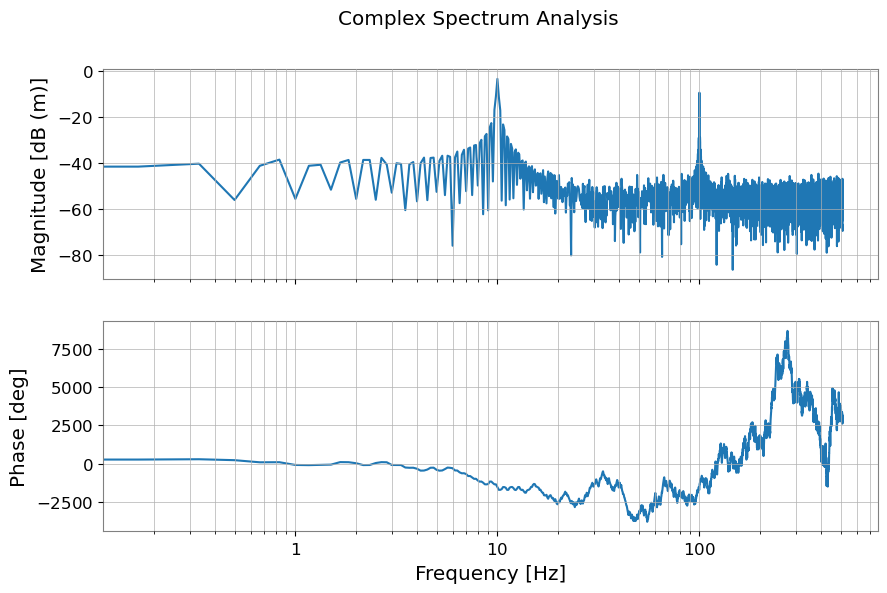

In [3]:
# 振幅を dB に変換 (ref=1.0, 20*log10)
spec_db = spec.to_db()

# 位相を取得 (度数表記、unwrap=True で連続化)
spec_phase = spec.degree(unwrap=True)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].semilogx(spec_db.frequencies, spec_db)
ax[0].set_ylabel('Magnitude [dB (m)]')
ax[0].grid(True, which='both')

ax[1].semilogx(spec_phase.frequencies, spec_phase)
ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which='both')
plt.suptitle('Complex Spectrum Analysis')
plt.show()

## 3. 周波数ドメインでの微積分

`differentiate_time()` および `integrate_time()` メソッドにより、周波数ドメインで微分・積分を行うことができます。
これは「変位・速度・加速度」の変換（$(2 \pi i f)^n$ の乗算）を簡単に行うための機能です。

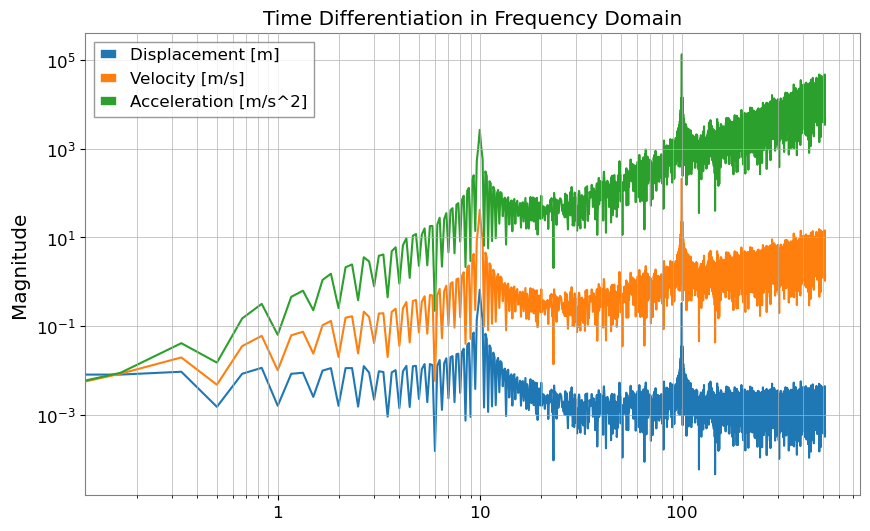

In [4]:
# 変位 (m) -> 速度 (m/s) に微分
vel_spec = spec.differentiate_time()

# 変位 (m) -> 加速度 (m/s^2) に 2回微分
accel_spec = vel_spec.differentiate_time()

plt.figure()
plt.loglog(spec.frequencies, np.abs(spec), label='Displacement [m]')
plt.loglog(vel_spec.frequencies, np.abs(vel_spec), label='Velocity [m/s]')
plt.loglog(accel_spec.frequencies, np.abs(accel_spec), label='Acceleration [m/s^2]')
plt.legend()
plt.grid(True, which='both')
plt.title('Time Differentiation in Frequency Domain')
plt.ylabel('Magnitude')
plt.show()

## 4. スペクトルのスムージングとピーク検出

### スムージング
`smooth()` メソッドを使用すると、移動平均などによるスペクトルの平滑化が可能です。

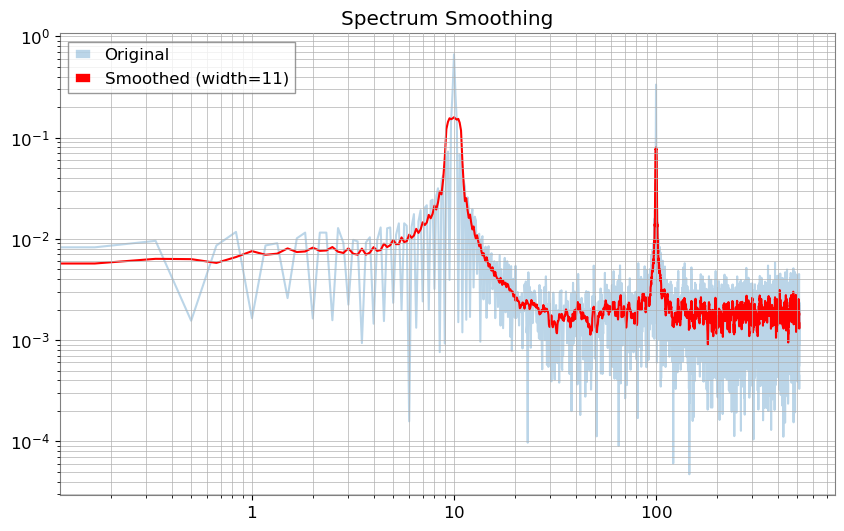

In [5]:
# 振幅ドメインで 11 サンプルのスムージング
spec_smooth = spec.smooth(width=11)

plt.figure()
plt.loglog(spec.frequencies, np.abs(spec), alpha=0.3, label='Original')
plt.loglog(spec_smooth.frequencies, np.abs(spec_smooth), color='red', label='Smoothed (width=11)')
plt.legend()
plt.grid(True, which='both')
plt.title('Spectrum Smoothing')
plt.show()

### ピーク検出
`find_peaks()` メソッドは `scipy.signal.find_peaks` をラップしており、特定の閾値を超えるピークを簡単に抽出できます。

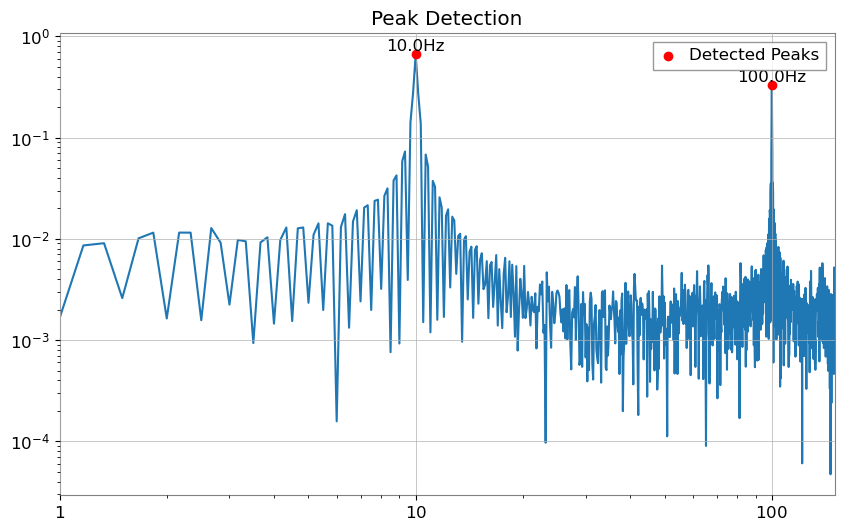

In [11]:
# 振幅 0.2 以上のピークを探す
peak_indices, props = spec.find_peaks(threshold=0.2)

peak_freqs = spec.frequencies[peak_indices]
peak_values = np.abs(spec[peak_indices])

plt.figure()
plt.plot(spec.frequencies, np.abs(spec))
plt.scatter(peak_freqs, peak_values, color='red', zorder=3, label='Detected Peaks')
for f, v in zip(peak_freqs.value, peak_values.value):
    plt.text(f, v, f"{f:.1f}Hz", ha='center', va='bottom')

plt.xlim(1, 150)
plt.xscale('log')
plt.yscale('log')
plt.title('Peak Detection')
plt.legend()
plt.show()

## 5. 高度な解析機能

### 群遅延 (Group Delay)
`group_delay()` メソッドは、位相の周波数微分から群遅延（信号のエンベロープの遅延）を計算します。

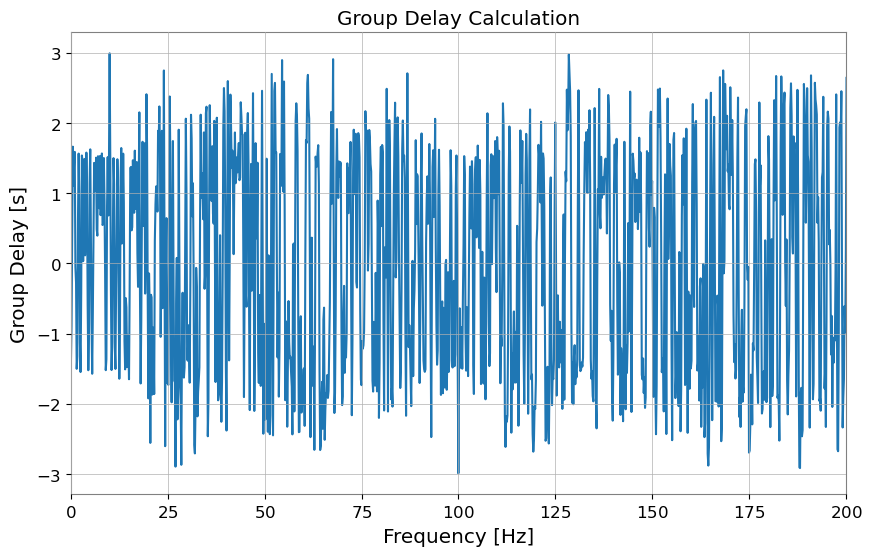

In [7]:
gd = spec.group_delay()

plt.figure()
plt.plot(gd.frequencies, gd)
plt.ylabel('Group Delay [s]')
plt.xlabel('Frequency [Hz]')
plt.xlim(0, 200)
plt.title('Group Delay Calculation')
plt.show()

### 逆FFT (ifft)
`ifft()` メソッドは、`TimeSeries` を返します。`mode="transient"` で FFT した結果であっても、情報を引き継いで元の長さに戻す (trim=True) などの制御が可能です。

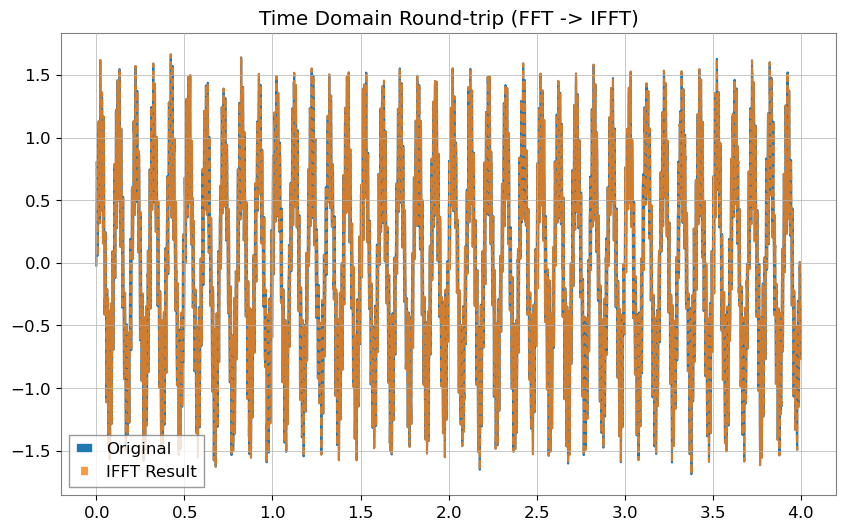

In [8]:
# 逆 FFT で TimeSeries に戻す
# mode="auto" は、入力 FrequencySeries が持つ transient 情報を読み取って適切に処理します
inv_ts = spec.ifft(mode="auto")

plt.figure()
plt.plot(ts, label='Original')
plt.plot(inv_ts, '--', label='IFFT Result', alpha=0.8)
plt.legend()
plt.title('Time Domain Round-trip (FFT -> IFFT)')
plt.show()

## 6. 他ライブラリとの連携

Pandas, xarray, control ライブラリとの相互変換が追加されています。

In [9]:
# Pandas Series へ変換
pd_series = spec.to_pandas()
print("Pandas index sample:", pd_series.index[:5])

# xarray DataArray へ変換
da = spec.to_xarray()
print("xarray coord name:", list(da.coords))

# control.FRD へ変換 (制御系の解析に使用可能)
try:
    from control import FRD
    frd_obj = spec.to_control_frd()
    print("Successfully converted to control.FRD")
except ImportError:
    print("python-control library not installed")

Pandas index sample: Index([0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666], dtype='float64', name='frequency')
xarray coord name: ['frequency']
Successfully converted to control.FRD
